In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *
from src.samplers import *
from src.metrics import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
GaussianMix = GaussianMixture.symmetric_2D(4,1.0)

gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer = FlowDiffTrainer(path=gaussian_path, modeltype="Diffusion", model=model1)

trainer.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 6.284045219421387
In Epoch 1000 we have a loss of 15.319812774658203
In Epoch 2000 we have a loss of 7.16707706451416
In Epoch 3000 we have a loss of 7.148178577423096
In Epoch 4000 we have a loss of 12.621027946472168
In Epoch 5000 we have a loss of 4.929245948791504
In Epoch 6000 we have a loss of 6.642634391784668
In Epoch 7000 we have a loss of 12.689851760864258
In Epoch 8000 we have a loss of 6.4904255867004395
In Epoch 9000 we have a loss of 5.9359259605407715
In Epoch 10000 we have a loss of 6.33266019821167
In Epoch 11000 we have a loss of 6.902026176452637
In Epoch 12000 we have a loss of 7.049371242523193
In Epoch 13000 we have a loss of 4.105361461639404
In Epoch 14000 we have a loss of 8.672471046447754
In Epoch 15000 we have a loss of 1150.66845703125
In Epoch 16000 we have a loss of 5.098341464996338
In Epoch 17000 we have a loss of 16.57910919189453
In Epoch 18000 we have a loss of 4.0360283851623535
In Epoch 19000 we have a loss of 9.648836

In [3]:
rec1 = Rectangle(device=device, coords= [(-5.0,5.0),(-10,10)])

gaussian_path2 = GaussianConditionalProbabilityPath(p_data=rec1, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model2 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer2 = FlowDiffTrainer(path=gaussian_path2, modeltype="Diffusion", model=model2)

trainer2.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 7.090925216674805
In Epoch 1000 we have a loss of 11.183250427246094
In Epoch 2000 we have a loss of 33.2095947265625
In Epoch 3000 we have a loss of 8.749666213989258
In Epoch 4000 we have a loss of 19.412046432495117
In Epoch 5000 we have a loss of 6.172762393951416
In Epoch 6000 we have a loss of 18.798969268798828
In Epoch 7000 we have a loss of 7.6460185050964355
In Epoch 8000 we have a loss of 5.625442981719971
In Epoch 9000 we have a loss of 5.952160358428955
In Epoch 10000 we have a loss of 13.639656066894531
In Epoch 11000 we have a loss of 5.931344509124756
In Epoch 12000 we have a loss of 6.351609230041504
In Epoch 13000 we have a loss of 4.816760063171387
In Epoch 14000 we have a loss of 37.679290771484375
In Epoch 15000 we have a loss of 10.31077766418457
In Epoch 16000 we have a loss of 31.959484100341797
In Epoch 17000 we have a loss of 5.630539417266846
In Epoch 18000 we have a loss of 11.615521430969238
In Epoch 19000 we have a loss of 9.65

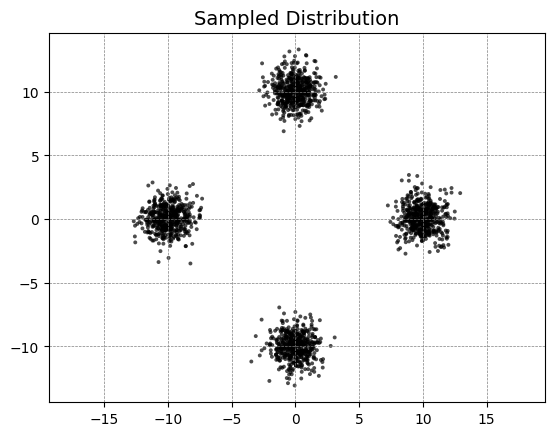

In [4]:
plot_samples(GaussianMix.sample(2000))
plt.show()

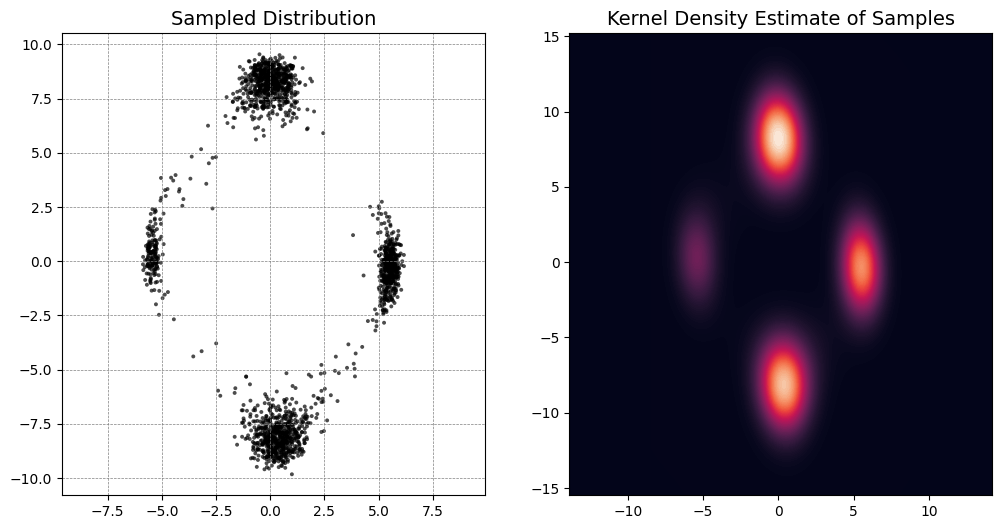

In [5]:
models = [model1,model2]

sde = CompLangevin(models=models, sigma = 0.5, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 
samples = comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps)
figsize=(12, 6)

fig, axes = plt.subplots(1, 2, figsize = figsize)
plot_samples(samples, ax=axes[0], kde=True)
plot_kde(samples, ax = axes[1], cmap="rocket")

plt.show()

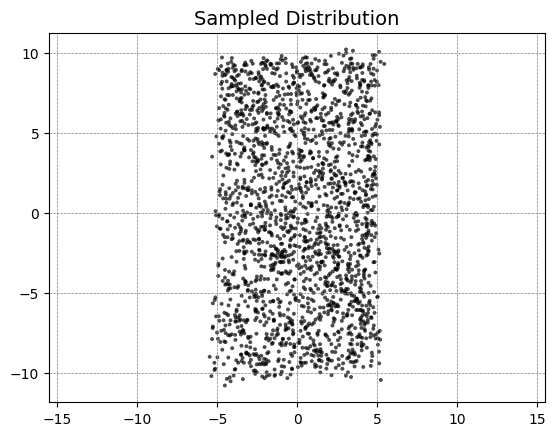

In [6]:
models = [model2]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.05, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps),contour=False)

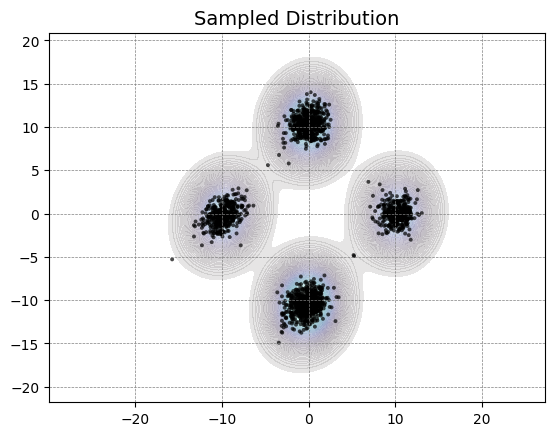

In [7]:
models = [model1]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_with_traj(gaussian_path.p_init.sample(2000), steps)[-1], scatter=True,kde=True)

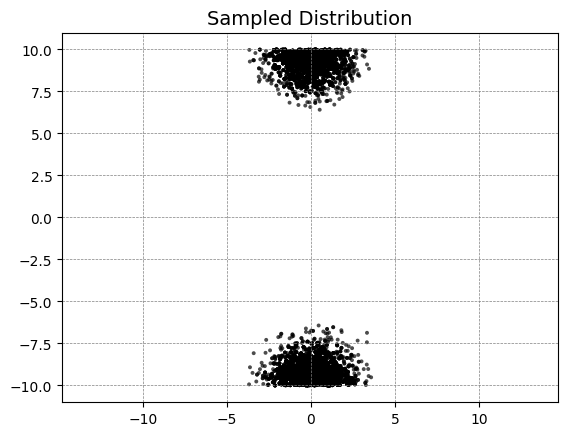

In [8]:
prod = ProductLogSample(densities=[GaussianMix, rec1], proposal_density=UnionLogSample(densities=[GaussianMix, rec1]))

plot_samples(prod.sample(11000))

In [9]:
#TODO: importance sampling for models, i.e. using one of the models as proposal (or something else? Maybe addition of scores or something in SDE) then standard IS
#TODO: DO Annealed for models 
#TODO: Metrics
#TODO: MORE EXAMPLES; TABELLE

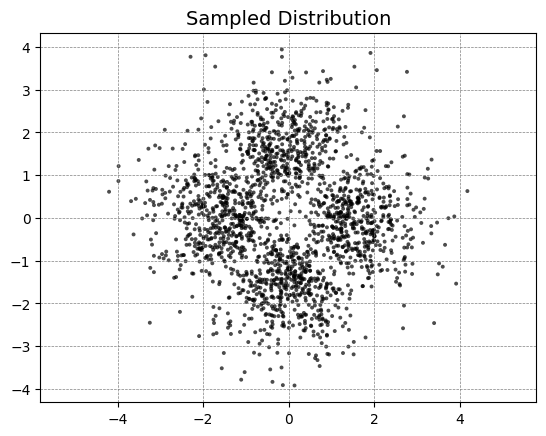

In [10]:
GaussianMix = GaussianMixture.symmetric_2D(4,1.0)
rec1 = Rectangle(device=device, coords= [(-5.0,5.0),(-10,10)])
gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)


sde = AnnealedProduct(densities=[GaussianMix], proposal_density=UnionLogSample(densities=[GaussianMix, rec1]), alpha=CosineAlpha(), sigma=0.5)

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.1, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) # [batch_size, num_steps, 1]

plot_samples(comp_sampler.sample_with_traj(gaussian_path.p_init.sample(2000), steps)[-1])

In [12]:
print_distribution_metrics(sample, samples)

=== Distances between Samples ===

 Wasserstein-2 Distance: 18.068662643432617

 Energy MMD: 1.5475468635559082

 Gaussian MMD: 0.09548947215080261
=== Coverge Metrics ===

 Precision, i.e. the fraction of generated Samples that fall into the neighborhood of any ground truth sample: 0.22599999606609344

 Recall, i.e. the fraction of real samples that fall into the neighborhood of any generated sample: 0.22599999606609344
